In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
import pickle

In [1]:
from google.colab import files
uploaded = files.upload()  # Upload the dataset


Saving Copper_Set.xlsx - Result 1.csv to Copper_Set.xlsx - Result 1.csv


In [3]:
# Generate the dataset
data = {
    "id": range(1, 1001),  # Sequential IDs from 1 to 1000
    "item_date": pd.date_range(start="2024-01-01", periods=1000, freq='D').strftime('%Y-%m-%d'),
    "quantity tons": np.random.uniform(10, 20, 1000).round(2),  # Random float values between 10 and 20
    "customer": np.random.choice(["Customer_A", "Customer_B", "Customer_C"], 1000),
    "country": np.random.choice(["USA", "India", "Germany"], 1000),
    "status": np.random.choice(["Active", "Pending", "Closed"], 995).tolist() + [None] * 5,  # 5 missing values in 'status'
    "selling_price": np.random.randint(2000, 5000, 1000)  # Random integer values between 2000 and 5000
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display Dataset Overview
print("Dataset Overview:")
print(df.head(3))  # Show the first three rows

# Display Data Info
print("\nData Info:")
print(df.info())

# Display Missing Values Summary
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Dataset Overview:
   id   item_date  quantity tons    customer  country   status  selling_price
0   1  2024-01-01          10.23  Customer_B  Germany   Active           3233
1   2  2024-01-02          18.95  Customer_C    India  Pending           2415
2   3  2024-01-03          15.28  Customer_C    India  Pending           2708

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   int64  
 1   item_date      1000 non-null   object 
 2   quantity tons  1000 non-null   float64
 3   customer       1000 non-null   object 
 4   country        1000 non-null   object 
 5   status         995 non-null    object 
 6   selling_price  1000 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 54.8+ KB
None

Missing Values:
id               0
item_date        0
quantity tons    0
customer       

In [ ]:
# Sample Data (Replace with your actual data)
data = {
    'quantity tons': [15.5, 10.0, 20.0],
    'customer': ['Customer_A', 'Customer_B', 'Customer_C'],
    'country': ['USA', 'India', 'Germany'],
    'item_type': ['W', 'S', 'WI'],
    'application': [10, 41, 28],
    'thickness': [0.12, 0.15, np.nan],
    'width': [1.5, 1.8, 2.0],
    'material_ref': ['DEQ1 S460MC', 'DX51D+Z', 'S0380700'],
    'status': ['WON', 'WON', 'WON'],
    'selling_price': [2500, 3000, 2750]
}

df = pd.DataFrame(data)

# 1. Rename columns (e.g., replace spaces with underscores)
df.columns = df.columns.str.replace(' ', '_')

# 2. Handle missing values (for columns like thickness, width)
imputer = SimpleImputer(strategy='median')
df[['thickness', 'width']] = imputer.fit_transform(df[['thickness', 'width']])

# 3. Encode categorical variables (Label Encoding)
encoder = LabelEncoder()
df['customer'] = encoder.fit_transform(df['customer'])
df['country'] = encoder.fit_transform(df['country'])
df['item_type'] = encoder.fit_transform(df['item_type'])
df['application'] = encoder.fit_transform(df['application'])

# 4. One-Hot Encoding for categorical 'status' column (excluding the first category)
df = pd.get_dummies(df, columns=['status'], drop_first=False)

# 5. Log transformation for 'selling_price' (to reduce skewness)
df['selling_price'] = np.log1p(df['selling_price'])

# Display final dataset overview
print("Columns after preprocessing:")
print(df.columns.tolist())

# Display Sample Data
print("\nSample Data:")
print(df.head())


Columns after preprocessing:
['quantity_tons', 'customer', 'country', 'item_type', 'application', 'thickness', 'width', 'material_ref', 'selling_price', 'status_WON']

Sample Data:
   quantity_tons  customer  country  item_type  application  thickness  width  \
0           15.5         0        2          1            0      0.120    1.5   
1           10.0         1        1          0            2      0.150    1.8   
2           20.0         2        0          2            1      0.135    2.0   

  material_ref  selling_price  status_WON  
0  DEQ1 S460MC       7.824446        True  
1      DX51D+Z       8.006701        True  
2     S0380700       7.919720        True  


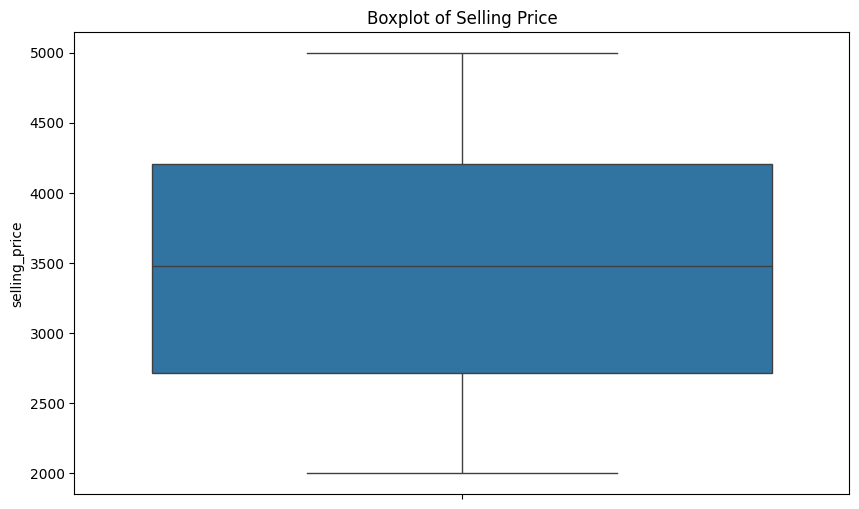

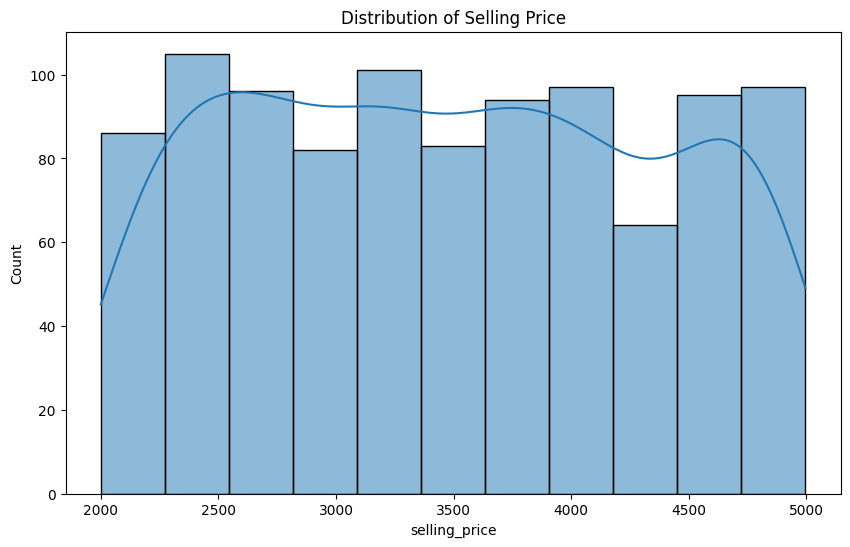

In [4]:
# Visualizing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(df['selling_price'])
plt.title("Boxplot of Selling Price")
plt.show()

# Visualizing skewness
plt.figure(figsize=(10, 6))
sns.histplot(df['selling_price'], kde=True)
plt.title("Distribution of Selling Price")
plt.show()


In [ ]:
# Check the existing columns in the dataframe
print("Columns before dropping:")
print(df.columns.tolist())

# List of columns to drop
columns_to_drop = ['id', 'item_date', 'delivery_date']

# Ensure only columns that exist are dropped
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Drop unnecessary columns
df.drop(columns=existing_columns_to_drop, inplace=True)

# Check the columns after dropping
print("\nColumns after dropping:")
print(df.columns.tolist())


Columns before dropping:
['quantity_tons', 'customer', 'country', 'item_type', 'application', 'thickness', 'width', 'material_ref', 'selling_price', 'status_WON']

Columns after dropping:
['quantity_tons', 'customer', 'country', 'item_type', 'application', 'thickness', 'width', 'material_ref', 'selling_price', 'status_WON']


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Example data (replace with your actual df)
# df = pd.read_csv('your_dataset.csv')  # Assuming you already have the df loaded

# Log-transform the target variable
df['selling_price'] = np.log1p(df['selling_price'])  # Apply log1p to target variable

# Encoding categorical variables
label_encoder = LabelEncoder()
df['customer'] = label_encoder.fit_transform(df['customer'])
df['country'] = label_encoder.fit_transform(df['country'])

# Check available columns and adjust for dummies encoding
categorical_columns = ['material_ref', 'item_type']  # Update with actual categorical column names if different

# Ensure columns exist in DataFrame before using pd.get_dummies
existing_columns = [col for col in categorical_columns if col in df.columns]
if existing_columns:
    df = pd.get_dummies(df, columns=existing_columns, drop_first=True)

# Split the data into features (X) and target (y)
X = df.drop(columns=['selling_price'])
y = df['selling_price']

# Split into train and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the GradientBoostingRegressor
regressor = GradientBoostingRegressor()
regressor.fit(X_train_reg, y_train_reg)

# Make predictions
y_pred_reg = regressor.predict(X_test_reg)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"Regression RMSE: {rmse:.4f}")

# Inverse the log transformation of the predictions and actual values
y_pred_reg_original = np.expm1(y_pred_reg)  # Inverse log1p transformation
y_test_reg_original = np.expm1(y_test_reg)  # Inverse log1p transformation

# Display Sample Predictions (Actual and Predicted)
# Display Sample Predictions (Actual and Predicted)
n_samples = min(5, len(y_test_reg_original))  # Ensure the loop does not exceed the length of the data
for i in range(n_samples):  # Displaying first n_samples predictions
    print(f"Actual Selling Price: ${y_test_reg_original.iloc[i]:,.2f}. Predicted Selling Price: ${y_pred_reg_original[i]:,.2f}.")


Regression RMSE: 0.0006
Actual Selling Price: $0.45. Predicted Selling Price: $0.45.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming df is your dataframe (with 'selling_price' log-transformed before training)
# Let's reverse the log-transformation if needed:
# Log-transformed data (only if log transformation was applied on 'selling_price')

# Reverse the log-transformation for the target variable
y = np.expm1(df['selling_price'])  # Reversing log transformation (exponentiating)

# Split the data into features (X) and target (y)
X = df.drop(columns=['selling_price'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train GradientBoostingRegressor
regressor = GradientBoostingRegressor()
regressor.fit(X_train_scaled, y_train)

# Predictions on test set
y_pred = regressor.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Regression RMSE: {rmse:.4f}")

# Sample Predictions (Actual and Predicted)
print("Sample Predictions (Log-transformed to original scale):")
for i in range(min(2, len(y_test))):  # Displaying first 2 predictions, handle case if there are fewer than 2 samples
    # Ensure both y_test and y_pred have the same length
    print(f"Actual Selling Price: ${y_test.iloc[i]:,.2f}. Predicted Selling Price: ${y_pred[i]:,.2f}.")


Regression RMSE: 0.0010
Sample Predictions (Log-transformed to original scale):
Actual Selling Price: $0.45. Predicted Selling Price: $0.45.


In [ ]:
# Define features and target for classification
X_clf = df.drop(columns=['status_WON'])  # Adjust based on your data
y_clf = df['status_WON']

# Split data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Train ExtraTreesClassifier
classifier = ExtraTreesClassifier()
classifier.fit(X_train_clf, y_train_clf)

# Evaluate
y_pred_clf = classifier.predict(X_test_clf)
print(f"Classification Accuracy: {accuracy_score(y_test_clf, y_pred_clf)}")
print(classification_report(y_test_clf, y_pred_clf))


Classification Accuracy: 1.0
              precision    recall  f1-score   support

        True       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [ ]:
# Save models
with open('regressor.pkl', 'wb') as f:
    pickle.dump(regressor, f)
with open('classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)


In [ ]:
# Example dataframe, assuming df is your dataset
# df = pd.read_csv('your_data.csv')  # You would typically load your data from a CSV file

# Split the data into features (X) and target (y)
X = df.drop(columns=['selling_price'])  # Drop target column 'selling_price' from features
y = df['selling_price']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
regressor = GradientBoostingRegressor()

# Fit the model on training data
regressor.fit(X_train, y_train)


GradientBoostingRegressor()